[View in Colaboratory](https://colab.research.google.com/github/nakabox/Week2_public/blob/master/Copy_of_Signal_Cleanup.ipynb)

# Smoothing/Interpolating and Filtering

Regardless of the experiment, noise (may also be referred to as random error) is an inevitable feature that introduces variability and "randomness" into the results. This is because it is impossible to completely remove or account for the source(s) that is/are causing noise. However, techniques exist that reduce noise without totally deprecating the underlying signal. Here, we will introduce the basics of smoothing/filtering and interpolating, including when and how to use them. Importantly, these techniques are typically used in combination to process a raw signal. In fact, smoothing/interpolation and filtering may be referenced interchangeably, especially with respect to functions/scripts that incorporate aspects of both.

Before we really get started, run the cell below to import the necessary packages for this notebook.

In [1]:
!pip install peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Chebyshev as T
import peakutils
from scipy.interpolate import *
from scipy.signal import *

  Running setup.py bdist_wheel for peakutils ... - done
  Stored in directory: /content/.cache/pip/wheels/1f/ee/00/e1378b61ba846a1eb898da7005254ee13fd09c3beeefefc3f2
Successfully built peakutils


## Smoothing/Interpolating

Definition: Simplistic, approximation function that plots important signal trends

Concept: Manipulate groups of adjacent points in a step-wise manner to define a smooth shape

Common Algorithms:
 - Additive/Laplacian Smoothing: Shifting probability from observed classes to nonobserved classes
 - Moving Average: Taking unweighted mean for shifting group of datapoints
 - Savitzky-Golay: Fitting low-degree polynomial for successive groups of datapoints
 - Smoothing Spline: Using cubic regression and derivatives to generate a smooth curve that passes through "knot" points

![alt text](https://image.ibb.co/hFMd7T/Smoothing.png)

For our smoothing/filtering dataset, we are going to be looking at employment in Wisconsin from 1961-1975, a highly relevant and interesting topic. The cell below will allow you to import and view the data.

In [2]:
data = pd.read_csv('https://github.com/BeaverWorksMedlytics/datasets/raw/master/WisconsinEmployment.csv')
data.head()

,Date,Value
0,1961-01,239.6
1,1961-02,236.4
2,1961-03,236.8
3,1961-04,241.5
4,1961-05,243.7


The cell below stores the values and dates in numpy ndarrays. In order to smoothly plot the data further down the line, the month number is converted to a fractional component of the year. For example, 1961-02 becomes 1961.08333.

In [0]:
values = np.ndarray(shape = (len(data['Value']),))
dates = np.ndarray(shape = (len(data['Date']),))

for counter, value in enumerate(data['Value']):
    values[counter] = value 
for counter, date in enumerate(data['Date']):
    temp = date.split('-')
    dates[counter] = int(temp[0]) + ((int(temp[1])-1) * 1/12)

The cell below contains a complete function for the moving average algorithm. Since this was covered in the signal processing introduction, just take several minutes to look at the code, make sense of it, and play around with the parameters.

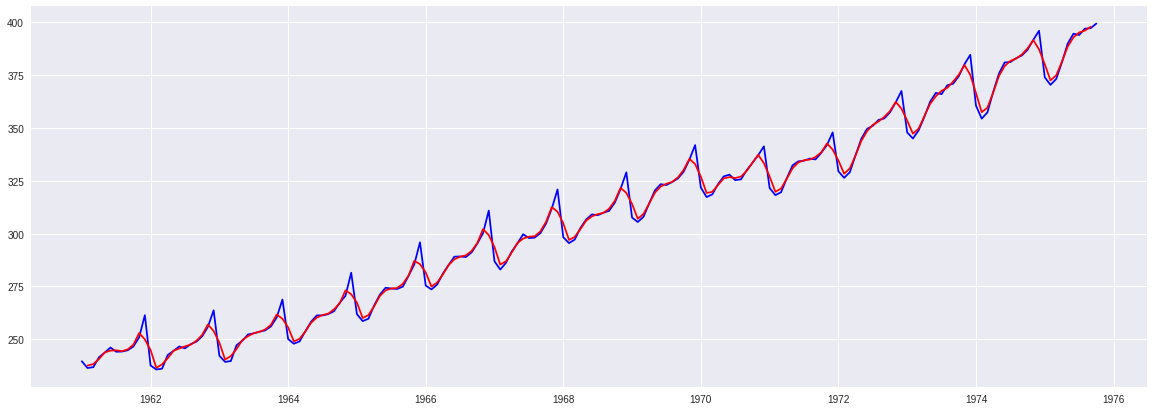

In [8]:
def moving_average(values, dates, frame):
    ma_size = values.shape[0]-frame+1
    ma_values = np.ndarray(shape=(ma_size,))
    ma_dates = np.ndarray(shape=(ma_size,))
    for i in range(ma_size):
        ma_values[i] = np.average(values[i:i+frame])
        if frame%2==1:
            ma_dates[i] = dates[(2*i+frame)//2]
        else:
            ma_dates[i] = dates[(2*i+frame)//2]-1/24
    return ma_values, ma_dates

ma_values, ma_dates = moving_average(values, dates, 3)

plt.figure(figsize = (20, 7))
plt.plot(dates, values, 'b')
plt.plot(ma_dates, ma_values, 'r')
plt.show()

The cell below contains an empty function for the Savitzky-Golay algorithm. The comments below will guide you on writing the correct implementation. If you want to know more about the math behind it, [click here](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter#Derivation_of_convolution_coefficients).

[[ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]]


ValueError: ignored

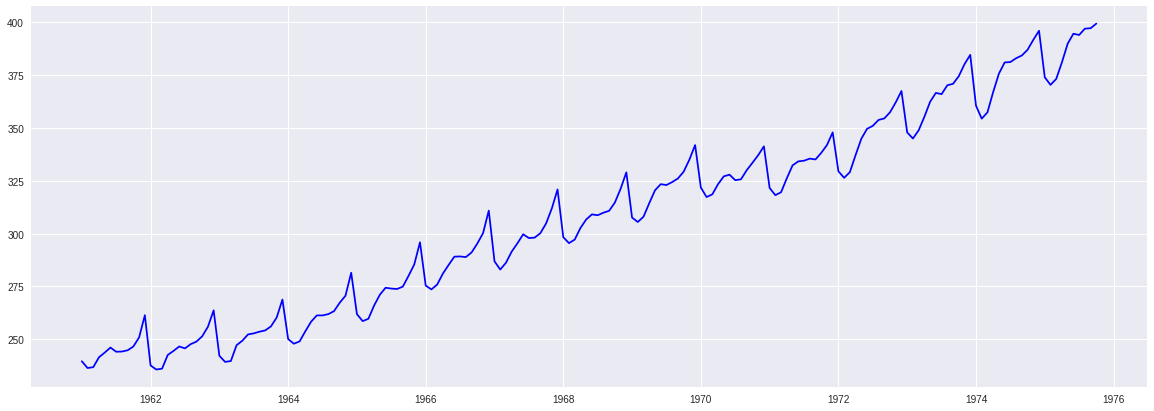

In [35]:
def savitzky_golay(values, frame, degree):
    # create a variable named half_window that contains the floor of half the frame 
    half_window = (frame//2)
    
    # create a numpy matrix that stores the coefficients for linear least squares (will be explained in detail on board)
    x = np.ndarray(shape = (frame, degree+1))
    
    for i in range(-half_window, half_window+1):
        for j in range(degree+1):
          x[i+half_window][j] = i**j
          
          
    print(x)
    
    x=np.mat(x)
    # calculate the pseudo-inverse of the numpy matrix (use np.linalg.pinv()) and store the first row of values
    
    convol = np.linalg.pinv(x).A[0]
    
    
    
    # artificially extend (use np.concatenate()) your input values at the start and end by the half_window
    
    firstvals = values[half_window:0:1]
    lastvals = values[-1:-half_window-1:-1]
    values = np.concatenate((firstvals,values,lastvals))
    
    # return a convolution on your coefficients and extended values (use np.convolve() with 'valid' mode)
    
    sg_values = np.convolve(convol,values,mode='valid')
    return sg_values

plt.figure(figsize = (20, 7))
plt.plot(dates, values, 'b')
plt.plot(dates, savitzky_golay(values, 7, 2), 'r')
#plt.plot(dates, savgol_filter(values, 7, 2), 'g')
plt.show()


The cell belows contain a complete function for the cubic smoothing spline algorithm. If you want to know more about the math behind it, [click here](https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation).

![alt_text](https://wikimedia.org/api/rest_v1/media/math/render/svg/9c6f5c5ebc1a07052c5a8eecf8bb8b4962dba585)
![alt_text](https://wikimedia.org/api/rest_v1/media/math/render/svg/88e32ef90f6de87831dca86ce217bd5a47d69dad)
![alt_text](https://wikimedia.org/api/rest_v1/media/math/render/svg/f50c100280b7fadfe16c7f3067589def1189ac12)

In [0]:
def smoothing_spline(x0, x, y):
    
    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    Li[0] = (2*xdiff[0])**(1/2)
    Li_1[0] = 0.0
    B0 = 0.0
    z[0] = B0 / Li[0]

    for i in range(1, size-1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = (2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1]**2)**(1/2)
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]
    
    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = (2*xdiff[-1] - Li_1[i-1]**2)**(1/2)
    Bi = 0.0
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    index = x.searchsorted(x0)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0
    
new_dates = np.linspace(min(dates), min(dates)+2, 2*len(dates))
plt.figure(figsize = (20, 7))
plt.plot(dates[:24], values[:24], 'b')
plt.plot(new_dates, smoothing_spline(new_dates, dates, values), 'r')
#lt.plot(new_dates, interp1d(dates, values, kind = 'cubic')(new_dates), 'g')
plt.show()

## Filtering

Definition: Elimination of unwanted features, typically frequencies, from a signal

Concept: Minimize the estimated contribution of noise when traversing through successive timepoints

Common Algorithms:
 - Fourier Transform: Decomposing signal into base frequencies
 - Kalman: Updating joint probability distributions of latent variables after every timepoint
 - Wiener: Minimizing mean square error between between actual and predicted output
 

For our filtering dataset, we are going to be looking at the superposition of three sine waves with different amplitudes and added noise. The cell below visualizes the data for you.

In [0]:
x = np.linspace(-20, 20, num = 200*np.pi)
y = [4, 13, 5, -3, 6, 30, 20, 19, 20, 21, 12, 11, 24, 20, 14, 15, 2, 14, 13, 3, 16, 28, 25, 22, 14, 17, 1, 16, 23, 21, 8, 11, 14, 8, 6, 20, 21, 25, 18, 23, 28, 4, 9, 13, 23, 22, 6, 8, 16, 2, 12, 25, 22, 12, 10, 12, 7, 6, 15, 24, 28, 9, 17, 8, 14, -3, 13, 35, 28, 13, 23, 24, 9, -2, 12, 34, 14, 17, 5, 4, 4, 11, 26, 33, 12, 11, 19, 13, 14, 11, 18, 21, 12, 12, 1, 11, 3, 16, 17, 25, 26, 15, 19, 6, 6, 32, 16, 16, 11, 10, 11, 8, 13, 31, 28, 20, 23, 19, 7, 2, 17, 20, 25, 2, 13, -2, 5, 3, 10, 29, 27, 10, 23, 26, 14, 11, 14, 22, 5, 9, 11, 3, 3, 8, 28, 22, 11, 12, 23, 14, 2, 10, 17, 20, 6, 13, 13, -1, 1, 17, 31, 28, 12, 19, 17, 4, 2, 25, 24, 8, 9, 10, 5, 0, 15, 24, 29, 18, 20, 20, 17, 12, 11, 26, 18, 18, 7, 11, 13, 9, 21, 21, 17, 20, 31, 18, 2, 15, 26, 27, 13, 12, 11, 5, -2, 11, 26, 27, 28, 15, 23, 12, 4, 16, 19, 22, 15, 3, 3, 4, 15, 19, 31, 23, 27, 18, 23, 10, 8, 26, 19, 17, 16, 5, 9, 1, 9, 19, 29, 9, 17, 19, 7, 12, 22, 25, 15, 19, 6, 11, 2, 12, 31, 19, 24, 8, 29, 18, 4, 16, 15, 27, 4, 1, 19, 2, -2, 14, 26, 19, 8, 22, 19, 11, 6, 17, 20, 14, 10, 3, 7, 11, 4, 14, 21, 22, 19, 23, 8, 13, 14, 23, 25, 22, 4, 4, 3, 4, 17, 25, 25, 20, 20, 23, 5, 14, 14, 28, 17, 10, 12, 12, -1, 4, 17, 27, 32, 24, 26, 18, 15, 8, 27, 17, 14, 12, 2, 5, -2, 4, 22, 25, 18, 12, 17, 12, 20, 8, 27, 9, 0, 17, 5, 3, 7, 26, 28, 26, 11, 19, 13, 4, 13, 27, 25, 2, 13, 14, 3, 4, 8, 28, 30, 17, 18, 15, 10, 11, 24, 11, 25, 15, 25, 11, 3, 0, 28, 25, 22, 15, 26, 22, 15, 13, 20, 18, 4, 8, 10, 4, 5, 25, 27, 15, 14, 16, 21, 9, 10, 18, 23, 7, 18, 14, 14, 1, 16, 21, 26, 26, 23, 12, 14, 7, 8, 17, 7, 13, 8, 19, 17, 15, 11, 35, 28, 18, 33, 20, 7, 0, 19, 25, 15, 7, 8, 10, 0, 2, 26, 38, 28, 24, 18, 13, 3, 19, 21, 13, 9, 12, 12, 7, 8, 13, 32, 31, 28, 13, 13, 3, 10, 18, 25, 15, 3, 12, -1, 4, 10, 20, 37, 15, 26, 8, 10, 7, 15, 32, 17, 9, 18, 11, 6, -3, 14, 22, 15, 14, 19, 8, 8, 11, 13, 22, 22, 16, 13, 12, 5, 10, 27, 25, 21, 20, 23, 12, 16, 25, 26, 27, 14, 20, 3, 7, 12, 25, 20, 25, 16, 18, 16, 9, 10, 28, 18, 6, 1, 9, 4, -1, 2, 32, 19, 21, 20, 21, 7, 13, 19, 24, 9, 15, 21, 9, 5, 3, 18, 16, 22, 7, 20, 12, 9, 10, 23, 28, 11, 4, 13, 2, -3, 9, 38, 26, 14, 14, 19, 16, 15, 24, 23, 13, 13, 9, 6, 5, 8, 15, 22, 22, 22, 23, 21, 14, 6, 20, 26, 8, 16, 7, 0, 7, 13, 28, 26, 11, 24, 14, 13, 0, 21, 13, 24, 17, 8, 11, -3, 6, 21, 26, 26, 21, 25, 16, 10, 10, 13, 23, 17, 10, 11, 4, 8, 6, 32, 21, 18, 18]

plt.figure(figsize = (20, 7))
plt.plot(x,y)
plt.show()

In the cell below, you will process this noisy signal using fourier transform and peak finding. You will return a "cleaned" version of the signal as well as the constituent sine signals.

In [0]:
# perform a fast fourier transform (use np.fft.rfft()), store the new x and y values, and plot these new values

# identify the peaks of the transform (use peakutils.peak.indexes()) and confirm that these are reasonable peaks for the transform

# filter the transform data by taking the transform values at each peak index while setting all other transform values to zero

# perform an inverse fast fourier transform (use np.fft.irfft()) and plot the "cleaned" signal

# repeat the last two steps for individual peak indexes to plot the constituent sine signals

The cell below contains an implementation of low-pass, high-pass, and band-pass filters, directly on raw data. More information on the implementation of these filters can be found [here](https://plot.ly/python/fft-filters/#lowpass-filter).

In [0]:
fL = 0.1
fH = 0.3
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
hlpf *= np.blackman(N)
hlpf = hlpf / np.sum(hlpf)
 
hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
hhpf *= np.blackman(N)
hhpf = hhpf / np.sum(hhpf)
hhpf = -hhpf
hhpf[int((N - 1) / 2)] += 1
 
h = np.convolve(hlpf, hhpf)
new_signal = np.convolve(values, h)

plt.figure(figsize = (20, 7))
plt.plot(new_signal)
plt.show()